# CDR: Gas Generator Design

> Author: Elias Aoubala

> Date: 21/04/2025

In [2]:
import numpy as np
import handcalcs.render
import pandas as pd
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
from scipy.interpolate import interpn
from rocketcea.cea_obj_w_units import CEA_Obj
from turborocket.transient.start_up import GasGenerator
from turborocket.combustion.comb_solver import CombustionCantera
from turborocket.fluids.fluids import IncompressibleFluid
import matplotlib.pyplot as plt

## 1 - Background

This document encapsulates the analysis conducted on the design of the gas-generator of the "Mermaidman and Barnacle Boy" turbopump, as part of the R2S 2025 competition.

This document describes the high level fluidic and mechanical design performed on the gas-generator used to drive the turbine for the turbopump.

## 2 - High Level Specification

The following high-level specifications have been used for the gas-generator operation, which is as follows:

| Parameter                 | Value       | Justification                                                         |
| ------------------------- | ----------- | --------------------------------------------------------------------- |
| Propellants               | N2O/IPA     | High Level Specification of the Mermaidman and Barnacle Boy Turbopump |
| Ignition System           | H2/O2 Torch | High Level Specification of the Mermaidman and Barnacle Boy Turbopump |
| Nitrous Delivery Pressure | 50 Bar      | Assumed Delivery Pressure from R2S Test-site (Protolaunch)            |
| IPA Delivery Pressure     | 50 Bar      | Target Exit Pressure of the Fuel Pump                                 |

## 3 - Mixture Ratio Sensitivity Study and Specification

A brief sensitivity study was performed to investigate how different O/F ratios would influence gas generator exhaust parameters.

The python library `rocketcea` was used to generate all fluidic parameters over a large range of mixture ratios.

In this study, a focus has been made primarily on fuel rich mixture ratios.

### 3.1 - Mixture Ratio and Chamber Pressure Study

One of the first steps that needs to be conducted in the sizing of the two components is to decided what the mixture ratio of the gas generator is. This is mainly driven on material requirements, with a maximum combustion gas temperature being acceptable.

In this case,  we have opted for a maxium gas temperature of the gas generator to be around **800 K**.

In [3]:
%%render

fuel = "Isopropanol"

ox = "N2O"


<IPython.core.display.Latex object>

In [4]:

cea = CEA_Obj(
    oxName=ox,
    fuelName=fuel,
    pressure_units="Bar",
    temperature_units="K",
    density_units="kg/m^3",
    specific_heat_units="J/kg-K",
)

ctr = CombustionCantera(fuel="C3H8O,2propanol",
                        oxidiser="N2O",
                        species_file="n2o_ipa.yaml",
                        look_up=False,
                        look_up_file = "combustion_date.csv")

#### 3.1.1 - Combustion Temperature

We can assume the following chamber conditions for the gas generator

Hard scripting to solve the interpolation problem!

In [5]:
df = pd.read_csv("combustion_date.csv")

# We then need to extract our properties
CP_array = df["Cp"].to_numpy()
CV_array = df["Cv"].to_numpy()
T_array = df["T"].to_numpy()
R_array = df["R"].to_numpy()

# We need to now now get the shape of the overarching mesh grid, which we can do by looking at unique values for the pressure and temperature
P_N = df["P"].unique().size

MR_N = df["MR"].unique().size

# We then resize our arrays and generate our x and y arrays
P_array = np.linspace(df["P"].min(), df["P"].max(), P_N)
MR_array = np.linspace(df["MR"].min(), df["MR"].max(), MR_N)

CP_array = CP_array.reshape(P_N, MR_N).T
CV_array = CV_array.reshape(P_N, MR_N).T
T_array = T_array.reshape(P_N, MR_N).T
R_array = R_array.reshape(P_N, MR_N).T

T = interpn((P_array, MR_array), T_array, [25e5, 1])

print(T)

T_add_can = ctr.get_thermo_prop(Pcc=25e5, MR=1).get_temperature()

print(T_add_can)

[1201.62028433]
1201.6185647200818


In [6]:
P_array = np.linspace(10, 35, 4)

O_F_array = np.arange(0.25, 6, 0.25)

T_add_array = np.zeros((O_F_array.size, P_array.size))

T_add_can_array = np.zeros((O_F_array.size, P_array.size))

i = 0
for o_f in O_F_array:

    k= 0
    for P in P_array:

        T_add = cea.get_Temperatures(Pc=P, MR=o_f)[0]

        T_add_can = ctr.get_thermo_prop(
            Pcc=P * 1e5, MR=o_f, frozen=False
        ).get_temperature()

        T_add_can_array[i, k] = T_add_can
        T_add_array[i, k]  = T_add

        k += 1

    i += 1

print(cea.get_Temperatures(Pc=20, MR=1)[0])

ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
E

Text(0.5, 1.0, 'Variation of Combustion Temperature with MR')

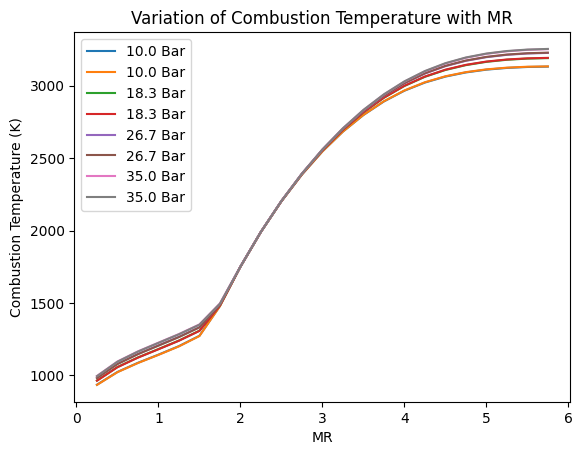

In [7]:
i = 0
for row in P_array:
    plt.plot(O_F_array, T_add_array[:, i], label = f"{row:0.1f} Bar")
    plt.plot(O_F_array, T_add_can_array[:, i], label=f"{row:0.1f} Bar")

    i += 1
plt.legend()
plt.xlabel("MR")
plt.ylabel("Combustion Temperature (K)")
plt.title("Variation of Combustion Temperature with MR")

As can be seen, the combustion temperatures are significantly higher than we can plausibly accept for any reasonable MR. We must however consider the injector performance, as this normally has second order impacts on the combustion temperature.

c* is defined as the following:

$c^* = \frac{P_c A_t}{\dot{m}}$

We can derive the relationship between c* and the gas temperature to be as follows:

$c^* = \sqrt{\frac{T R}{\gamma} \left( \frac{\gamma + 1}{2} \right) ^{\frac{\gamma + 1}{\gamma -1 }})}$

We can assume thay any efficiency impact has negligible impact to the specific heat ratio of the specific gas constant of the resultant mixture, but only with the combustion temperature. Hence we can derive the following relationship for the $c^*$ efficiency with combustion temperature

$\eta_{c^*} = \frac{c^*_{act}}{c^*_{theo}} = \frac{\sqrt{T_{act}}}{\sqrt{T_{theo}}}$

Thus we can derive the actual combustion temperature as follows:

$T_{act} = T_{theo} \eta_{c^*}^2$

It should be noted that the assumption made that gas composition and specific heat ratio remain constant are unverified and can be gross, but it can be proximate for first pass sizing. The following c* efficiency has been assumed

In [8]:
%%render

eta_c = 0.85

<IPython.core.display.Latex object>

Based on this c* efficiency, we can now back calculate what our new combustion temperatures will be for the gas generators:

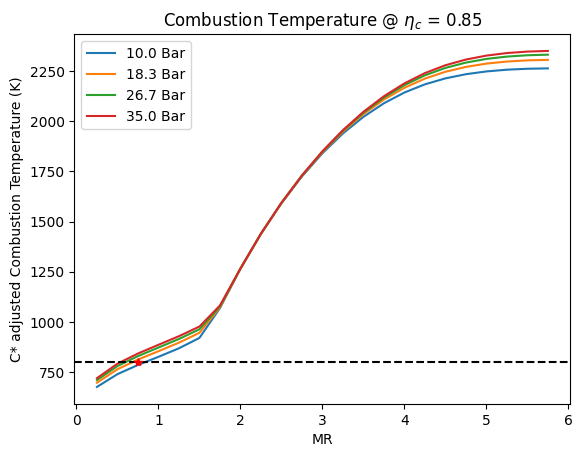

In [9]:
i = 0
for row in P_array:
    plt.plot(O_F_array, T_add_array[:, i] * eta_c**2, label = f"{row:0.1f} Bar")
    
    i += 1

plt.legend()
plt.xlabel("MR")
plt.ylabel("C* adjusted Combustion Temperature (K)")
plt.title(fr"Combustion Temperature @ $\eta_c$ = {eta_c:0.2f}")
plt.axhline(800, linestyle="--", color="k")
plt.plot(0.75, 800, marker="*", color="r")

#### 3.1.2 - Specific Heat Capacity

Another quite improtant parameter to consider is the specific heat capacity of the gas, this will have critical implications on the required mass flow rate needed for the gas generator.

In [10]:
P_array = np.array([25])

O_F_array = np.linspace(0.05, 8, 50)

cp_add_array = np.zeros((O_F_array.size, P_array.size))

cp_cant_array = np.zeros((O_F_array.size, P_array.size))

cp_cant_fz_array = np.zeros((O_F_array.size, P_array.size))

T_add_array = np.zeros((O_F_array.size, P_array.size))

i = 0
for o_f in O_F_array:

    k= 0
    for P in P_array:

        Cp_add = cea.get_Chamber_Cp(Pc=P, MR=o_f)

        cp_cant = ctr.get_thermo_prop(
            Pcc=P * 1e5, MR=o_f, frozen=False
        ).get_cp()

        cp_cant_fz = ctr.get_thermo_prop(Pcc=P * 1e5, MR=o_f).get_cp()

        cp_add_array[i, k]  = Cp_add

        cp_cant_array[i, k] = cp_cant

        cp_cant_fz_array[i, k] = cp_cant_fz

        k += 1

    i += 1

ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!


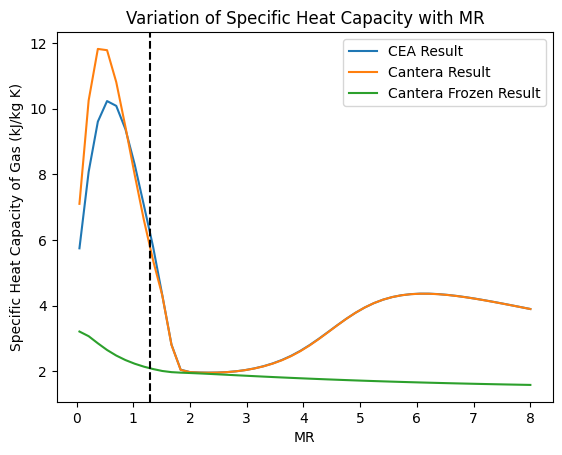

In [11]:
i = 0
for row in P_array:
    plt.plot(O_F_array, cp_add_array[:, i]/1e3, label = f"CEA Result")
    plt.plot(O_F_array, cp_cant_array[:, i] / 1e3, label=f"Cantera Result")
    plt.plot(O_F_array, cp_cant_fz_array[:, i] / 1e3, label=f"Cantera Frozen Result")

    i += 1
plt.legend()
plt.xlabel("MR")
plt.ylabel("Specific Heat Capacity of Gas (kJ/kg K)")
plt.title("Variation of Specific Heat Capacity with MR")
plt.axvline(1.3, linestyle="--", color="k")

#### 3.1.3 - Specific Heat Ratio

Another key parameter that is influential to the design of the turbopump, is the specific heat ratio ($\gamma$), which has been plotted below.

In [12]:
P_array = np.linspace(5, 30, 5)

O_F_array = np.linspace(0.05, 2.25, 50)

R_array = np.zeros((O_F_array.size, P_array.size))

gamma_array = np.zeros((O_F_array.size, P_array.size))

i = 0
for o_f in O_F_array:

    k = 0
    for P in P_array:

        gamma = cea.get_Chamber_MolWt_gamma(Pc=P, MR=o_f)[1]

        gamma_array[i, k] = gamma

        R_array[i, k] = Cp_add*(gamma - 1)/gamma

        k += 1

    i += 1

Text(0.5, 1.0, 'Specific Heat Ratio at varying MR')

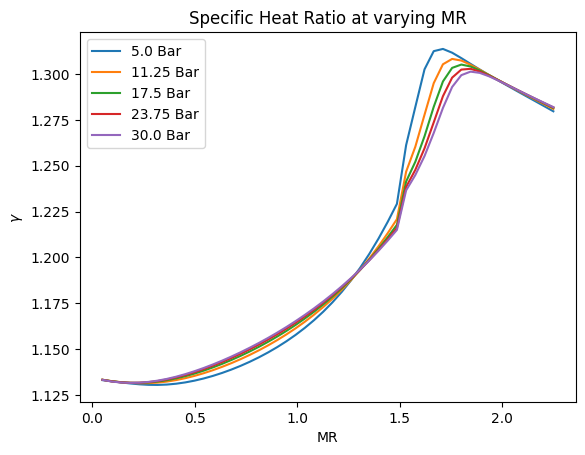

In [13]:
i = 0
for row in P_array:
    plt.plot(O_F_array, gamma_array[:, i], label = f"{row} Bar")
    
    i += 1

plt.legend()
plt.xlabel("MR")
plt.ylabel(r"$\gamma$")
plt.title(fr"Specific Heat Ratio at varying MR")


#### 3.1.4 - Specific Gas Constant

The specific gas constant is an important parameter, as this will directly influence the gas generator exhaust density and thus areas producted for both the rotor and the stator.

In [14]:
P_array = np.linspace(5, 30, 5)

O_F_array = np.linspace(0.05, 2.25, 50)

R_array = np.zeros((O_F_array.size, P_array.size))

gamma_array = np.zeros((O_F_array.size, P_array.size))

i = 0
for o_f in O_F_array:

    k = 0
    for P in P_array:

        Cp_add = cea.get_Chamber_Cp(Pc=P, MR=o_f)

        gamma = cea.get_Chamber_MolWt_gamma(Pc=P, MR=o_f)[1]

        gamma_array[i, k] = gamma

        R_array[i, k] = Cp_add*(gamma - 1)/gamma

        k += 1

    i += 1

Text(0.5, 1.0, 'Specific Gas Constant at varying MR')

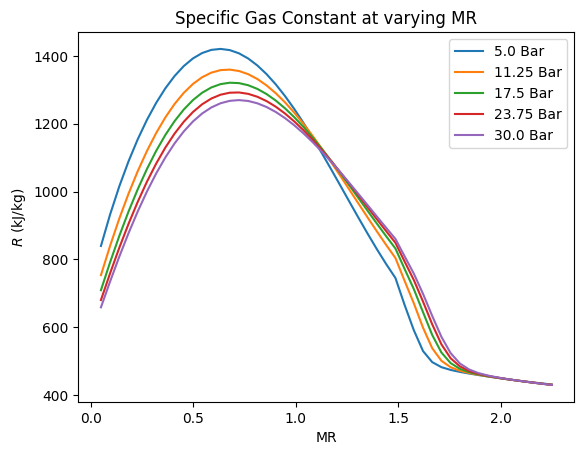

In [15]:
i = 0
for row in P_array:
    plt.plot(O_F_array, R_array[:, i], label = f"{row} Bar")
    
    i += 1

plt.legend()
plt.xlabel("MR")
plt.ylabel(r"$R$ (kJ/kg)")
plt.title(fr"Specific Gas Constant at varying MR")


#### 3.1.5 - Conclusion

For the gas-generator, we fundementally desire a high specific gas constant (implying low gas density) and thus workable areas, high specific heat capacity (implying higher enthalpy) and low specific gas constant (implying shock losses are lower), hence we can oprt for an O/F of **0.75 at 30 Bar**.

### 3.2 - Start-up Ignitability

It is of uptmost importance that we ensure that the gas-generator is capable of igniting at startup, where the nitrous pressure delivery will be high, while the IPA pressure is low as the pump begins to spin-up.

This section of the analysis investigated this phenomena to see if ignitability is possible at initial low pressure IPA igntion.

The key criteria for driving ignitability here will be mixing (indirectly computed via injector stifness), along with resultant MR at ignition.

Based on discussions with the pump designer Craig, the following inlet pressure is expected for the design:

| Parameter                 | Value  | Justification                               |
| ------------------------- | ------ | ------------------------------------------- |
| Start-up IPA Pressure     | 20 Bar | Specific Inlet Pressure of the IPA pump     |
| Start-up Nitrous Pressrue | 50 Bar | Test-site delivery pressure for the Nitrous |

Simple Injection Modelling has been used for thes two fluids, with no "two-phase" flow assumptions being applied for the Nitrous line.

#### 3.2.1 - Injector Modelling

The simple equation for incompressible flow through a infinitesimly thin orfice has been used.

It has been assumed that the discharge coefficient remains constant and is indepenedent of pressure drop.


$$\dot{m} = C_d A \sqrt{2 \rho (P_1 - P_2)}$$

Where $P_1$ refers to the delivery pressure, $P_2$ refers to the combustion chamber pressure, $\rho$ refers to the propellant density and $C_d A$ referse to the orifice effective area.

We can divide this mass-flow rate by the throat area of the chamber, and encapsule the constant elements of the equation into a single parameter.

$$\frac{\dot{m}}{A_c} = \frac{C_d A \sqrt{2 \rho}}{A_c} \sqrt{P_1 - P_c} = K \sqrt{P_1 - P_c}$$

Now if we were to compare the ox and fuel sides, we can derive these parameters based on one another as we already know the target mixture ratio of the system:

$$MR = \frac{\dot{m}_{ox}}{\dot{m}_f} = \frac{\dot{m}_{ox}}{A_c} \frac{A_c}{\dot{m}_{f}} = \frac{K_{ox} \sqrt{P_{ox} - P_c}}{K_{f} \sqrt{P_f - P_c}}$$

As we already know the pressure drops of the system under the target case, we can thus derive the relationship between these two parameters accordingly by re-arranging in the following manner:

$$K_{ox} \sqrt{P_{ox} - P_c} = K_{f} \sqrt{P_f - P_c} MR $$

$$K_{ox} = K_{f} \frac{\sqrt{P_f - P_c} MR}{\sqrt{P_{ox} - P_c} } $$

$$K_{ox} = \alpha K_{f}$$

#### 3.2.2 - Chamber Modelling

A simple isentropic choked flow assumption will be used for the chamber modelling at this stage.

$$\dot{m} = \frac{A P_c}{\sqrt{T_o}} \sqrt{\frac{\gamma}{R}} \left( \frac{\gamma + 1}{2} \right)^{-\frac{\gamma + 1}{2 ( \gamma -1 )}}$$

We can re-arrange this by dividing by the throat area, to get the following relationship:

$$\frac{\dot{m}}{A_c} = \frac{P_c}{\sqrt{T_o}} \sqrt{\frac{\gamma}{R}} \left( \frac{\gamma + 1}{2} \right)^{-\frac{\gamma + 1}{2 ( \gamma -1 )}}$$

We can go on to equate the left hand side to the sum of the orifice flows from both the oxidiser and fuel to get the following:

$$K_{ox} \sqrt{P_{ox} - P_c} + K_{f} \sqrt{P_{f} - P_c}= \frac{P_c}{\sqrt{T_o}} \sqrt{\frac{\gamma}{R}} \left( \frac{\gamma + 1}{2} \right)^{-\frac{\gamma + 1}{2 ( \gamma -1 )}}$$

We can employ that factor relationship we defined previously between the two orifices, to thus get the following:

$$K_{f} \left( \alpha\sqrt{P_{ox} - P_c} + \sqrt{P_{f} - P_c} \right)= \frac{P_c}{\sqrt{T_o}} \sqrt{\frac{\gamma}{R}} \left( \frac{\gamma + 1}{2} \right)^{-\frac{\gamma + 1}{2 ( \gamma -1 )}}$$

From here, we can set our target pressure for delivery (P_ox and P_f, and directly solve for the chamber pressure) and conditions.

We can back calculate the mixture ratios by doing the following:

$$MR = \alpha \frac{\sqrt{P_{ox} - P_c}}{\sqrt{P_f - P_c}}$$


This can be done for a range of K_f values to give us an idea of how gas-generator mass-flow influences the start-up O/F of the engine, where K_f is equal to the following:

$$K_f = \frac{(C_d A)_f \sqrt{2 \rho_f}}{A_c} $$

There is three key variables which influence this variation in set-point, namely the nominal chamber pressure ($P_c$), the target MR (influences $\alpha$) and engine size ($K_f$).

A case study has been performed for a theoretical 500 N gg to evaluate how this drift would occur.


#### 3.2.3 - Parameteric Study

Defining our key parameters for the engine

**Chamber Parameter**

In [16]:
%%render param sci_not

Pcc = 25e5 # Pa
MR_nom = 1
eta_c = 0.85
m_dot_t = 28e-3 # kg/s


<IPython.core.display.Latex object>

**Injector Parameters**

Fuel Side:

In [17]:
%%render param sci_not

Pf_inlet = 50e5 # Pa
rho_f_inlet = 786 # kg/s
Cd_f = 0.4

<IPython.core.display.Latex object>

Oxidiser Side:

In [18]:
%%render param sci_not

Po_inlet = 50e5 # Pa
rho_o_inlet = CP.PropsSI("D", "P", Po_inlet, "Q", 0, "NitrousOxide") # kg/s
Cd_o = 0.5

<IPython.core.display.Latex object>

We then define our classes for the gas generator

In [19]:
Nitrous = IncompressibleFluid(
    rho=rho_o_inlet, P=Po_inlet
)
IPA = IncompressibleFluid(rho=rho_f_inlet, P=Pf_inlet)

GG = GasGenerator(
    Ox="N2O", Fu="C3H8O,2propanol", Pcc=Pcc, MR=MR_nom
)  # , look_up_file="combustion_date.csv"

GG.comb_object(
    look_up=False, combustion_file="n2o_ipa.yaml", look_up_file="combustion_date.csv"
)

In [20]:
GG.injector_cond(ox_in=Nitrous, fu_in=IPA, cdo=Cd_o, cdf=Cd_f)

GG.size_system(m_dot=m_dot_t, eta_c=eta_c)

{'P_cc': 2500000.0,
 'MR': np.float64(1.0),
 'T_o': 868.1694130102591,
 'Cp': 2242.4288383607086,
 'gamma': 1.290332008352664,
 'R': 504.5591863293963,
 'ox_stiffness': 1.0,
 'fu_stiffness': 1.0,
 'm_dot_t': np.float64(0.028),
 'm_dot_o': np.float64(0.014),
 'm_dot_f': np.float64(0.014)}

In [21]:
GG.get_geometry()

{'CdA_ox': np.float64(2.2295336243513932e-07),
 'CdA_fu': np.float64(2.233221295279437e-07),
 'A_fu': np.float64(5.583053238198592e-07),
 'A_ox': np.float64(4.4590672487027863e-07),
 'Acc': np.float64(1.1138387445876008e-05)}

We can now sweep through a range of inlet pressures on the fuel side and see how differing the injector stiffness, combustion temperatures and the mixture ratios vary

In [22]:
P_inlet_array = np.linspace(25, 70, 100)*1e5

P_cc_array = []
MR_array = []
T_o_array = []
cp_array = []
gamma_array = []
ox_stiff_array = []
fu_stiff_array = []
m_dot_t_array = []
m_dot_ox_array = []
m_dot_fu_array = []
error_array = []

for p in P_inlet_array:

    fuel = IncompressibleFluid(rho=rho_f_inlet, P=p)

    dic = GG.solve_perturb_ss(fu_in=fuel, ox_in=Nitrous)

    P_cc_array.append(dic["P_cc"])
    MR_array.append(dic["MR"])
    T_o_array.append(dic["T_o"])
    cp_array.append(dic["Cp"])
    gamma_array.append(dic["gamma"])
    ox_stiff_array.append(dic["ox_stiffness"])
    fu_stiff_array.append(dic["fu_stiffness"])
    m_dot_t_array.append(dic["m_dot_t"])
    m_dot_ox_array.append(dic["m_dot_o"])
    m_dot_fu_array.append(dic["m_dot_f"])
    error_array.append(dic["error"])

ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
ERROR: FAILURE its = 1001!
E

Text(0.5, 0, 'Fuel Inlet Pressure (Bar)')

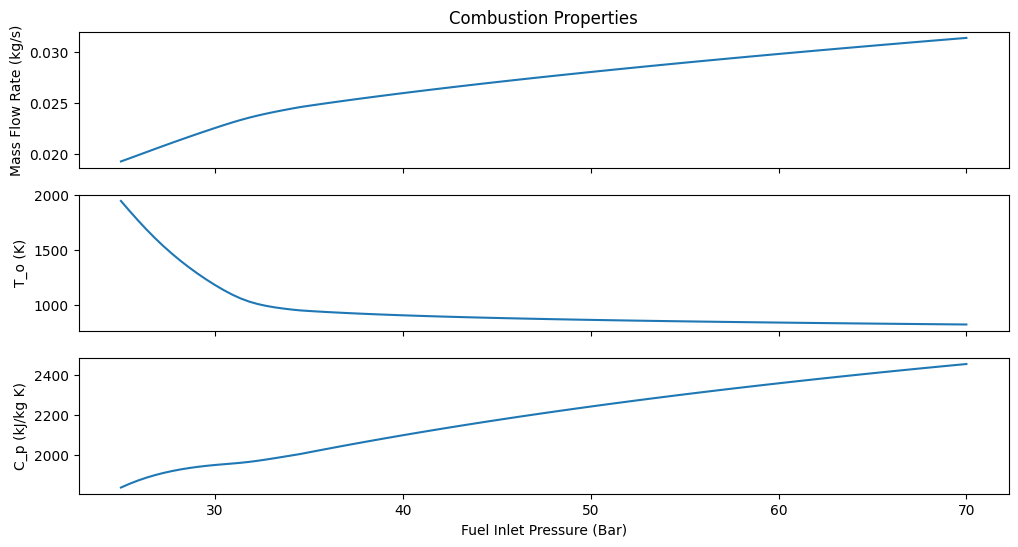

In [23]:
fig, ax = plt.subplots(3, 1, sharex=True)

fig.set_size_inches(12, 6)

# First Plot will be Mass Flow
ax[0].plot(P_inlet_array / 1e5, m_dot_t_array)
ax[0].set_ylabel("Mass Flow Rate (kg/s)")
ax[0].set_title("Combustion Properties")


# Second Plot will be Stagnation Temperature
ax[1].plot(P_inlet_array / 1e5, T_o_array)
ax[1].set_ylabel("T_o (K)")


# Thrid Plot will be Specific Heat Capacity
ax[2].plot(P_inlet_array / 1e5, cp_array)
ax[2].set_ylabel("C_p (kJ/kg K)")
ax[2].set_xlabel("Fuel Inlet Pressure (Bar)")

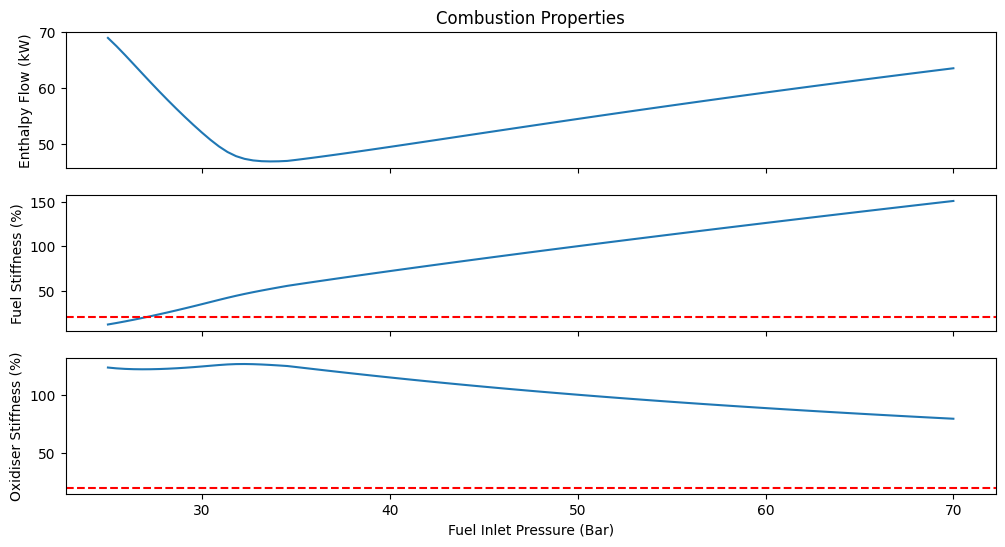

In [24]:
fig, ax = plt.subplots(3,1, sharex=True)

fig.set_size_inches(12, 6)

# First Plot will be the Total Enthalpy Delivered
enthalpy_flow = np.array(m_dot_t_array) * np.array(cp_array) * np.array(T_o_array)
ax[0].plot(P_inlet_array/1e5, enthalpy_flow/1e3)
ax[0].set_ylabel("Enthalpy Flow (kW)")
ax[0].set_title("Combustion Properties")


# Second Plot will be Fuel Stiffness
ax[1].plot(P_inlet_array/1e5, np.array(fu_stiff_array)*100)
ax[1].set_ylabel("Fuel Stiffness (%)")
ax[1].axhline(20, linestyle="--", color="r")


# Thrid Plot will be Oxidiser Stiffness
ax[2].plot(P_inlet_array/1e5, np.array(ox_stiff_array)*100)
ax[2].set_ylabel("Oxidiser Stiffness (%)")
ax[2].set_xlabel("Fuel Inlet Pressure (Bar)")
ax[2].axhline(20, linestyle="--", color="r")

Text(0.5, 0, 'Fuel Inlet Pressure (Bar)')

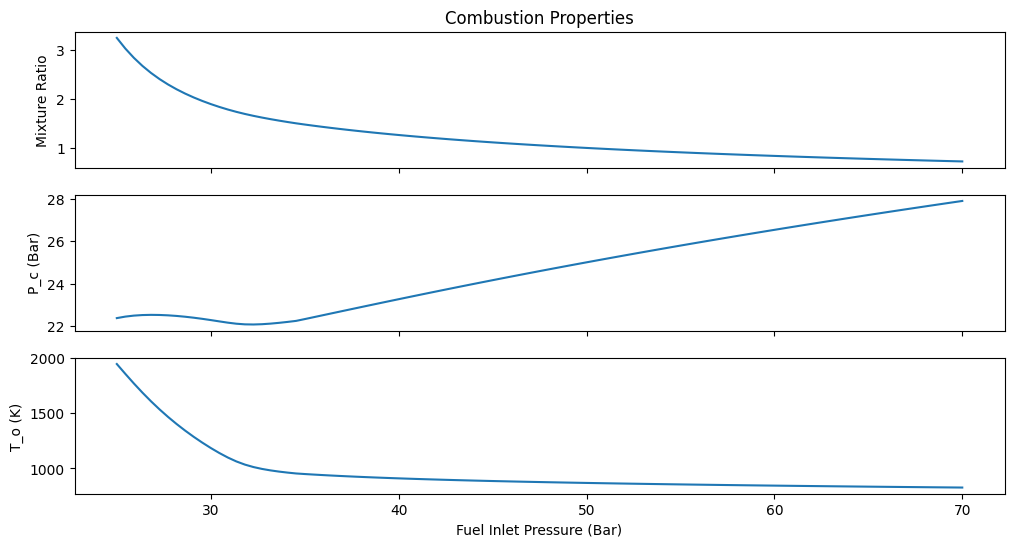

In [25]:
fig, ax = plt.subplots(3, 1, sharex=True)

fig.set_size_inches(12, 6)

# First Plot will be Mixture Ratio
ax[0].plot(P_inlet_array / 1e5, MR_array)
ax[0].set_ylabel("Mixture Ratio")
ax[0].set_title("Combustion Properties")


# Second Plot will be Chamber Pressure
ax[1].plot(P_inlet_array / 1e5, np.array(P_cc_array) / 1e5)
ax[1].set_ylabel("P_c (Bar)")


# Thrid Plot will be Stagnation Temperature
ax[2].plot(P_inlet_array / 1e5, T_o_array)
ax[2].set_ylabel("T_o (K)")
ax[2].set_xlabel("Fuel Inlet Pressure (Bar)")

## 4 - Conclusion and Baseline

Based on the sensitivity studies conducted, a MR of 1 has been selected as the baseline for the gas generator.

The following key parameters for the combustion performance to feed the turbine design have been derived.

In [28]:
Nitrous.set_pressure(P=Pf_inlet)
IPA.set_pressure(P=50e5)

GG.injector_cond(ox_in=Nitrous, fu_in=IPA, cdo=Cd_o, cdf=Cd_f)

GG.size_system(m_dot=34.698e-3, eta_c=eta_c)

{'P_cc': 2500000.0,
 'MR': np.float64(1.0),
 'T_o': 868.1694130102591,
 'Cp': 2242.4288383607086,
 'gamma': 1.290332008352664,
 'R': 504.5591863293963,
 'ox_stiffness': 1.0,
 'fu_stiffness': 1.0,
 'm_dot_t': np.float64(0.034698),
 'm_dot_o': np.float64(0.017349),
 'm_dot_f': np.float64(0.017349)}

In [29]:
GG.get_geometry()

{'CdA_ox': np.float64(2.762869917776594e-07),
 'CdA_fu': np.float64(2.7674397322716395e-07),
 'A_fu': np.float64(6.918599330679098e-07),
 'A_ox': np.float64(5.525739835553188e-07),
 'Acc': np.float64(1.3802848842750204e-05)}

## 5 - Combustion Solver Plot